In [2]:
%matplotlib inline

In [3]:
path = "data/redux/"

In [4]:
import utils; reload(utils)
from utils import*

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [5]:
batch_size=64

# Create validation set and sample

In [6]:
%cd data/redux

/home/ubuntu/Fastai/nbs/data/redux


In [8]:
%mkdir valid

In [7]:
%cd train

/home/ubuntu/Fastai/nbs/data/redux/train


In [10]:
g = glob("*.jpg")
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], '../valid/' + shuf[i])

In [11]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [8]:
from shutil import copyfile

In [13]:
g = glob("*.jpg")
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [9]:
%cd ../valid

/home/ubuntu/Fastai/nbs/data/redux/valid


In [15]:
g = glob("*.jpg")
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], '../sample/valid/' + shuf[i])

# Move sets to separate directories

In [16]:
%cd ../train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/Fastai/nbs/data/redux/train


In [52]:
%cd ../valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/Fastai/nbs/data/redux/valid


In [53]:
%cd ../sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/Fastai/nbs/data/redux/sample/train


In [54]:
%cd ../valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/Fastai/nbs/data/redux/sample/valid
mkdir: cannot create directory ‘cats’: File exists
mkdir: cannot create directory ‘dogs’: File exists
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory


# Finetune and Train

In [10]:
from vgg16 import Vgg16

In [11]:
vgg = Vgg16()

In [12]:
%cd ../../../

/home/ubuntu/Fastai/nbs


In [102]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [103]:
vgg.fit(batches, val_batches, nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 632s - loss: 0.1168 - acc: 0.9690 - val_loss: 0.0891 - val_acc: 0.9745
Epoch 2/2
23000/23000 [==============================] - 632s - loss: 0.0935 - acc: 0.9783 - val_loss: 0.0759 - val_acc: 0.9815


In [66]:
%mkdir data/redux/results

In [104]:
vgg.model.save_weights(path+'results/ft1.h5')

In [105]:
vgg.model.optimizer.lr = 0.01

In [106]:
vgg.fit(batches, val_batches, nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 632s - loss: 0.1017 - acc: 0.9781 - val_loss: 0.1048 - val_acc: 0.9760
Epoch 2/2
23000/23000 [==============================] - 632s - loss: 0.0949 - acc: 0.9797 - val_loss: 0.0774 - val_acc: 0.9845


In [107]:
vgg.model.save_weights(path+'results/ft2.h5')

# Submit

In [ ]:
%mkdir data/redux/test/unknown

In [ ]:
%mv data/redux/test/*.jpg data/redux/test/unknown

In [13]:
batches, preds = vgg.test(path+'test', batch_size=batch_size*2)

Found 12500 images belonging to 1 classes.


In [14]:
filenames = batches.filenames

In [15]:
save_array(path+'results/test_preds.dat', preds)
save_array(path+'results/filenames.dat', filenames)

In [16]:
preds = load_array(path+'results/test_preds.dat')
filenames = load_array(path+'results/filenames.dat')

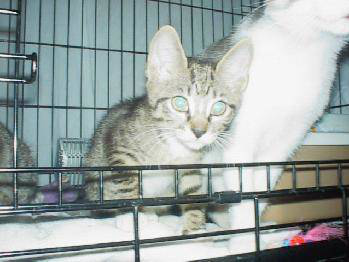

In [17]:
from PIL import Image
Image.open(path+'test/' + filenames[0])

In [18]:
isdog = preds[:,1]
isdog[:5]

array([  7.5661e-08,   2.8813e-06,   6.2873e-06,   2.4023e-05,   2.7270e-07], dtype=float32)

In [19]:
isdog = np.clip(preds[:,1], 0.02,0.98)

In [20]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [22]:
subm = np.stack([ids, isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   2.0000e-02],
       [  1.2026e+04,   2.0000e-02],
       [  9.6880e+03,   2.0000e-02],
       [  4.3920e+03,   2.0000e-02],
       [  7.7900e+02,   2.0000e-02]])

In [23]:
np.savetxt('data/redux/subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [24]:
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

/home/ubuntu/Fastai/nbs/data/redux/subm98.csv

# Checking results

In [25]:
vgg.model.load_weights(path+'results/ft2.h5')

In [26]:
val_batches, probs = vgg.test(path+'valid', batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [27]:
labels = val_batches.classes
filenames = val_batches.filenames

In [28]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[0:8]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [29]:
preds[0:8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [30]:
# number of images to view for each task
n_view = 4

In [33]:
def plots_idx(ids, titles=None):
    plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

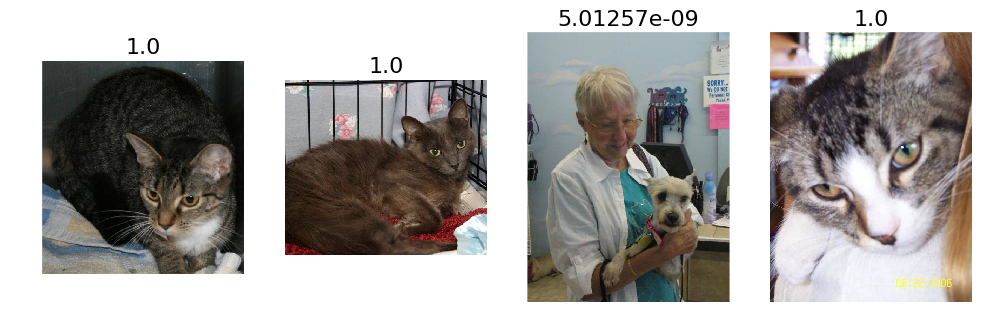

In [34]:
#1. A few correct labels at random
correct = np.where(preds == labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

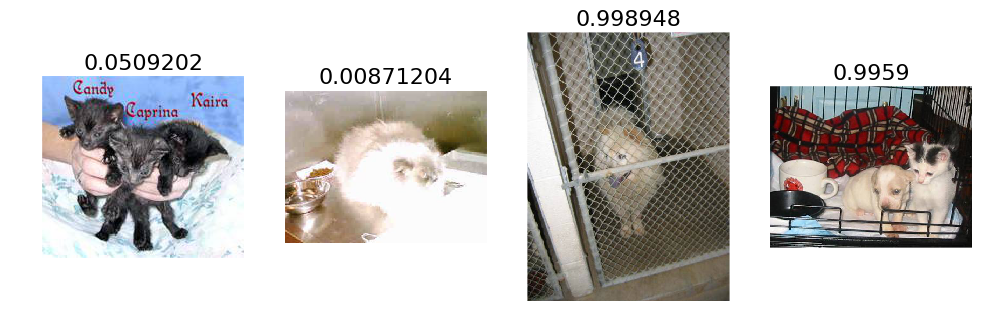

In [35]:
#2. A few incorrect labels at random
incorrect = np.where(preds != labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

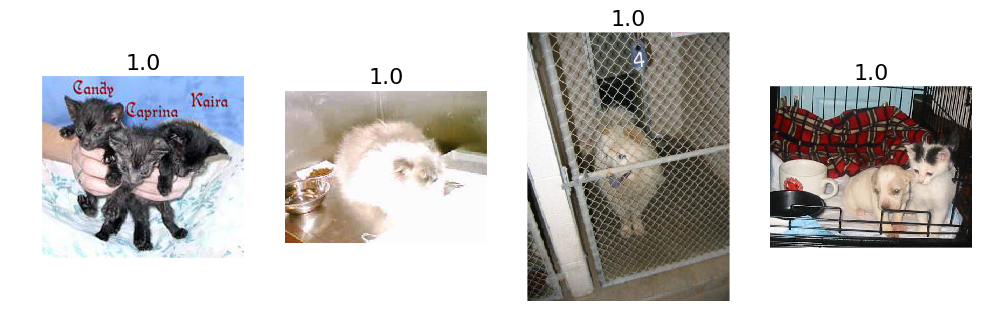

In [38]:
#3. The images with most confidence where cat are actually cats
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

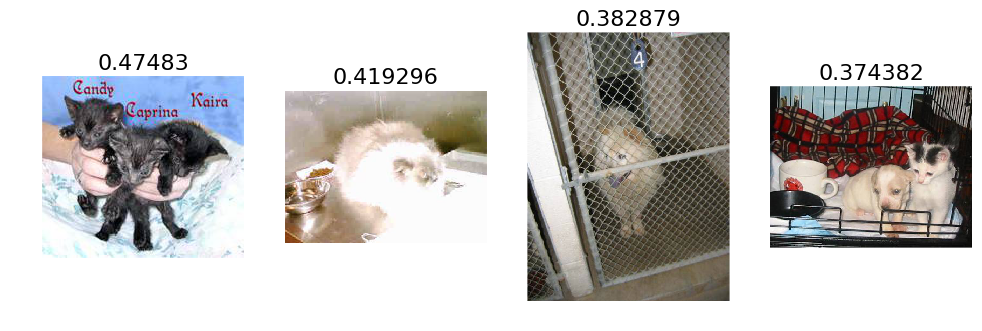

In [40]:
#4. The images with most confidence where dogs are actually dogs
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

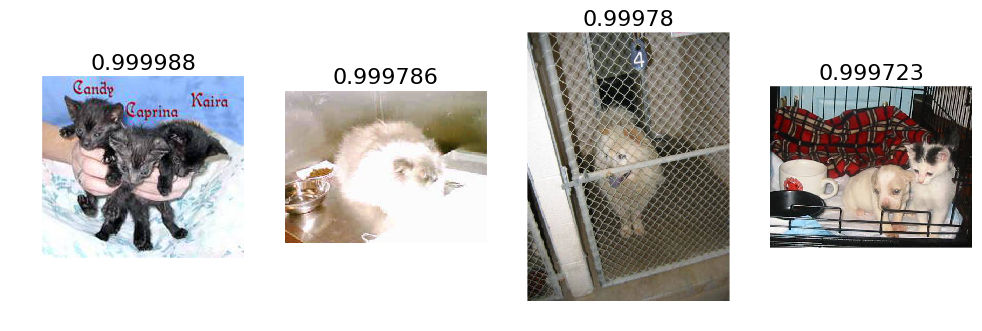

In [42]:
#5. The images with most confidence where cat are actually not cats
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

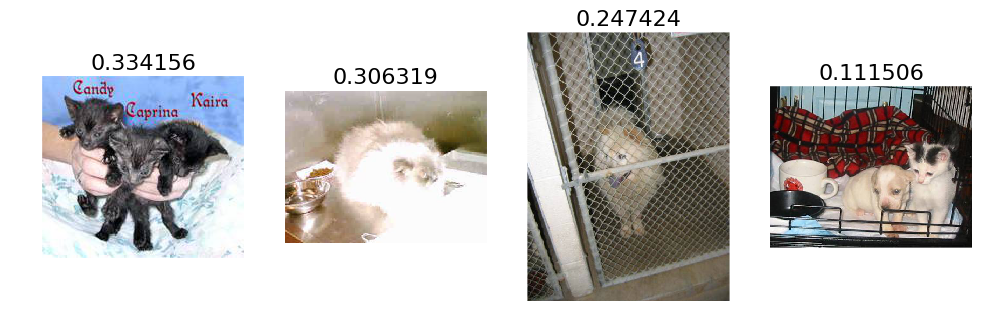

In [44]:
#6. The images with most confidence where dogs are actually not dogs
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])